In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [10]:
# Carregar dataset (ajuste o caminho se necessário)
df = pd.read_csv("data/tripadvisor_european_restaurants.csv")

# Selecionar automaticamente colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remover linhas com NaN
df_num = df[numeric_cols].dropna()

print("Número total de linhas antes da amostragem:", len(df_num))
df_num.head()


C:\Users\Thiago\AppData\Local\Temp\ipykernel_3192\2387833331.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/tripadvisor_european_restaurants.csv")


Número total de linhas antes da amostragem: 199542


,latitude,longitude,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere
9,48.231495,5.973734,6.0,53.00,6.0,4.5,244.0,1.0,1.0,0.0,0.0,0.0,0.0,4.5,4.5,4.5,4.5
20,43.315636,6.075663,6.0,20.25,8.0,4.5,126.0,1.0,0.0,1.0,0.0,0.0,0.0,4.5,4.5,4.0,4.0
21,43.315327,6.075969,7.0,52.50,14.0,4.0,117.0,2.0,0.0,1.0,0.0,1.0,0.0,4.0,4.0,4.0,4.0
26,49.230675,0.720579,7.0,38.50,14.0,4.0,240.0,17.0,8.0,7.0,0.0,0.0,2.0,4.0,4.0,4.0,4.0
27,49.231590,0.720728,7.0,28.00,14.0,4.0,167.0,18.0,12.0,5.0,1.0,0.0,0.0,4.0,4.0,4.0,4.0


In [11]:
# Amostragem aleatória: 5000 linhas (aceito academicamente)
df_sample = df_num.sample(n=5000, random_state=0)

print("Amostra:", df_sample.shape)

scaler = StandardScaler()
X_s = scaler.fit_transform(df_sample.values)

print("Formato dos dados padronizados:", X_s.shape)

Amostra: (5000, 17)
Formato dos dados padronizados: (5000, 17)


Usando todas as features padronizadas: (5000, 17)
Matriz de linkage gerada com sucesso!


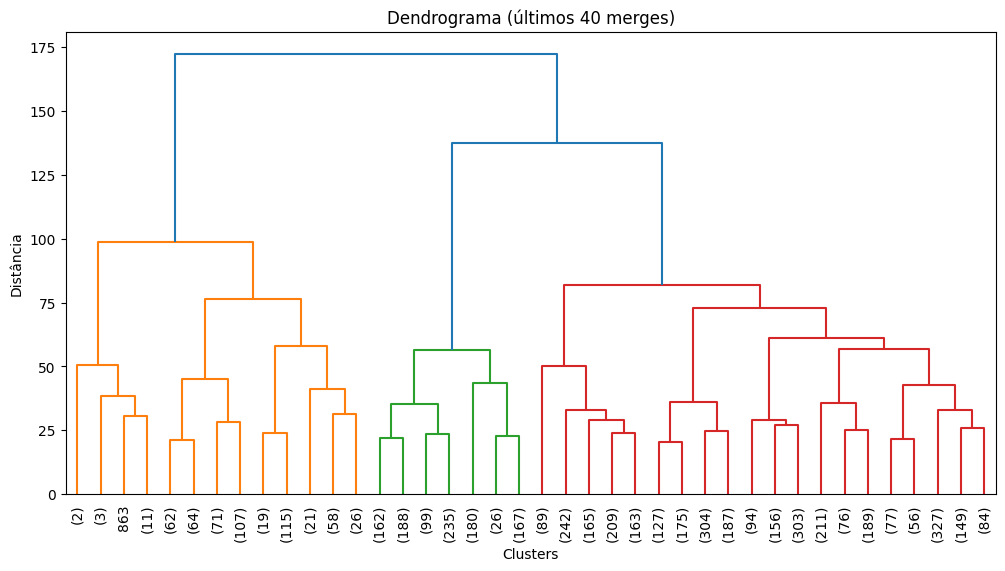

In [12]:
use_pca = False  # mude para True se quiser tornar o linkage MUITO mais leve

if use_pca:
    pca = PCA(n_components=2)
    X_used = pca.fit_transform(X_s)
    print("Usando PCA para linkage:", X_used.shape)
else:
    X_used = X_s
    print("Usando todas as features padronizadas:", X_used.shape)

Z = linkage(X_used, method='ward')

print("Matriz de linkage gerada com sucesso!")


plt.figure(figsize=(12,6))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=40,
    leaf_rotation=90.,
    leaf_font_size=10.
)
plt.title("Dendrograma (últimos 40 merges)")
plt.xlabel("Clusters")
plt.ylabel("Distância")
plt.show()

Clusters gerados: [1 2 3 4]
Silhouette (hierarchical): 0.18097561816666216
Silhouette (KMeans): 0.19949172112253963


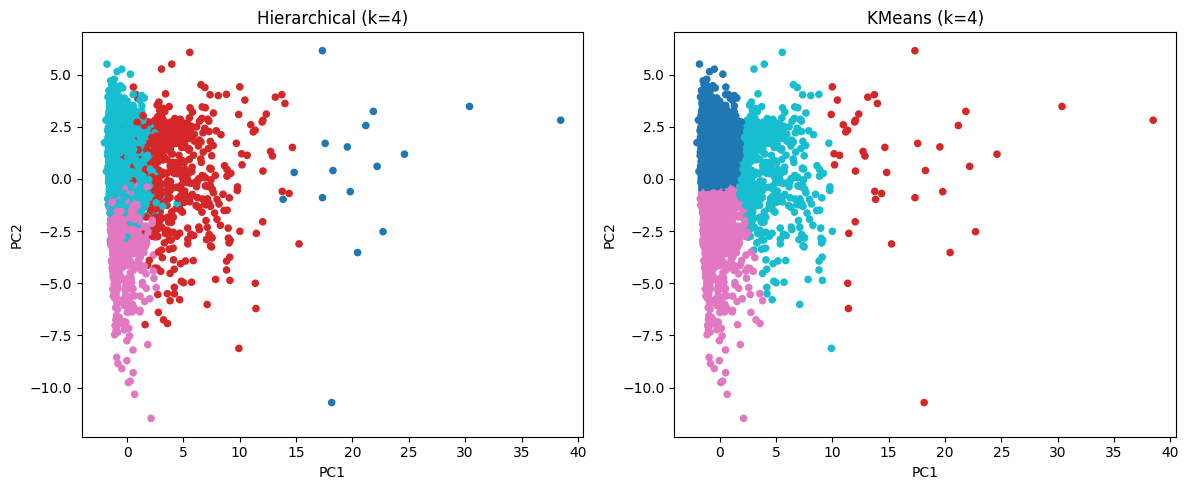

In [13]:
k = 4  # você pode alterar

labels_h = fcluster(Z, k, criterion='maxclust')

print("Clusters gerados:", np.unique(labels_h))
print("Silhouette (hierarchical):", silhouette_score(X_used, labels_h))

km = KMeans(n_clusters=k, random_state=0, n_init=10)
labels_km = km.fit_predict(X_used)

print("Silhouette (KMeans):", silhouette_score(X_used, labels_km))

pca_vis = PCA(n_components=2)
proj2 = pca_vis.fit_transform(X_used)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(proj2[:,0], proj2[:,1], c=labels_h, cmap='tab10', s=20)
plt.title(f'Hierarchical (k={k})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1,2,2)
plt.scatter(proj2[:,0], proj2[:,1], c=labels_km, cmap='tab10', s=20)
plt.title(f'KMeans (k={k})')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

In [14]:
df_summary = df_sample.copy()
df_summary['cluster_hier'] = labels_h
df_summary['cluster_kmeans'] = labels_km

display(df_summary.groupby('cluster_hier').mean())
display(df_summary.groupby('cluster_kmeans').mean())

,latitude,longitude,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,cluster_kmeans
cluster_hier,,,,,,,,,,,,,,,,,,
1,50.628040,0.457250,6.588235,76.452941,6.764706,3.941176,4359.764706,2419.588235,1233.117647,603.352941,281.588235,145.588235,155.941176,4.088235,3.941176,3.852941,3.823529,1.000000
2,50.066186,1.530665,6.609576,65.775200,7.556169,4.114180,981.723757,645.561694,364.311234,148.303867,60.648250,34.983425,37.314917,4.162063,4.134438,3.963168,4.041436,2.397790
3,47.720949,4.855739,6.693472,72.187748,7.881741,3.456481,188.298013,55.756859,18.353832,16.420057,8.121097,5.212867,7.649007,3.562441,3.508515,3.445128,3.472564,1.899716
4,46.112933,5.650883,6.250074,55.747630,8.302986,4.215489,272.247709,79.211942,46.272835,19.906887,6.378067,3.234407,3.419746,4.285841,4.219923,4.117499,4.117647,0.437777


,latitude,longitude,open_days_per_week,open_hours_per_week,working_shifts_per_week,avg_rating,total_reviews_count,reviews_count_in_default_language,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,cluster_hier
cluster_kmeans,,,,,,,,,,,,,,,,,,
0,46.307952,5.742386,6.175906,53.112396,8.003909,4.298330,278.895878,80.992182,51.062189,18.734897,5.637527,2.750888,2.806681,4.367271,4.312544,4.206468,4.213042,3.921109
1,51.360769,-0.075222,6.697674,73.039535,7.441860,4.058140,2997.953488,1940.372093,1064.023256,458.069767,202.674419,106.860465,108.744186,4.162791,4.081395,3.895349,4.011628,1.604651
2,46.670390,5.275202,6.640625,70.159986,8.503005,3.594050,240.357572,59.874399,20.974760,18.203125,8.341947,5.093149,7.261418,3.690805,3.611478,3.537861,3.544171,3.370793
3,50.749677,0.322763,6.686848,67.989805,7.611691,4.102296,863.375783,642.177453,355.701461,151.941545,61.419624,35.724426,37.390397,4.141962,4.125261,3.960334,4.038622,2.283925
